In this Notebook, we aim at creating some DataDriven surrogate models for the simpliest 1D Poisson Equation: 

$$
- D \Delta u = 1
$$

with D the diffusion coefficient, considerer as scalar and constant over the whole domain. 

Our goal is to create params to solutions models, i.e a mapping from D to u.  

As we want to do it in a data driven manner, we first need a solver to generate data. To do so, we use an implicit finite difference method. 
$$
-D \frac{u_{i-1} -2u_i + u_{i+1}}{(\Delta x)^2} = 1
$$

In [16]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import random as rd
import copy

In [2]:
current_folder = os.path.dirname(os.path.abspath('__file__'))
parent_folder = os.path.dirname(current_folder)
grandparent_folder = os.path.dirname(parent_folder)
sys.path.append(grandparent_folder)

## Data Generation

First we need to generate data, to do so, we use the Solver module that will do everything for us in exchange for a dictionnary of params as input. 

There is some already recorded params in the config_step_1.py file 

In [3]:
from solvers.Solver import Solver
from config_step_1 import PARAMS_SOLVER

Poisson equation in a \[0, 1\] domain and 1001 points for discretizations

In [4]:
PARAMS_SOLVER

{'equation': 'Poisson', 'domain': [0.0, 1.0], 'D': 1.0, 'nx': 1001}

In [22]:
params_solver = copy.deepcopy(PARAMS_SOLVER)
solver = Solver(params={'solver': params_solver})

In [6]:
u = solver.solve()

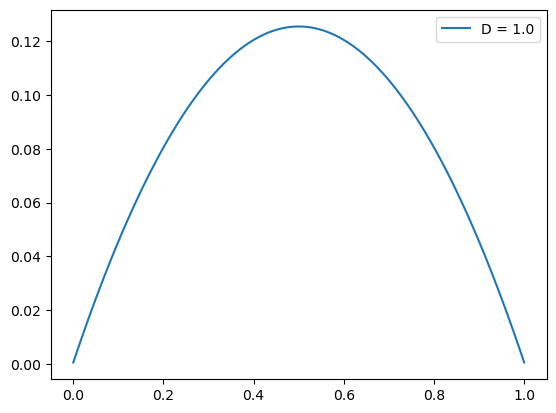

In [7]:
plt.plot(solver.x, u, label=f'D = {solver.D}')
plt.legend()
plt.show()

Now let us generate a dataset using this solver

In [8]:
Dmin, Dmax = 1, 10
D_list = np.linspace(Dmin, Dmax, 10)

In [9]:
U_sols = []
for d in D_list:
    solver.change_D(d)
    U_sols.append(solver.solve())

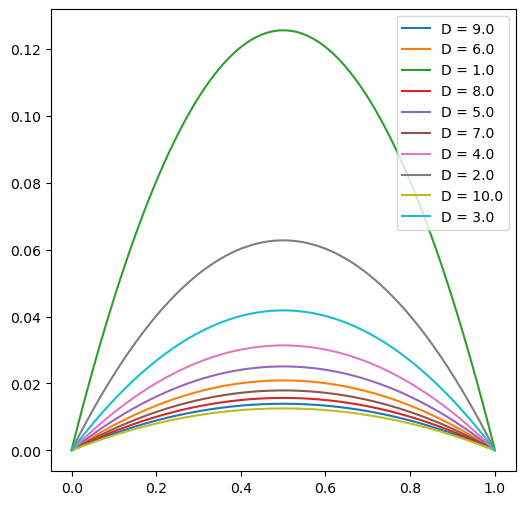

In [10]:
fig, axs = plt.subplots(1, figsize=(6, 6))
for sample in rd.sample(range(0, len(U_sols)), 10):
    axs.plot(solver.x, U_sols[sample], label=f'D = {D_list[sample]}')
plt.legend()
plt.show()

## DataDriven surrogate models creation

Now we want to create multiple surrogate models through different methods: POD, MLP, FNO and DeepONet

In [24]:
from methods.DataDrivenMethods import DDMethod

In [25]:
method_names = ['POD'] 

In [26]:
from config_step_1 import PARAMS_METHODS

In [28]:
all_methods = {}
for method in method_names:
    params_method = copy.deepcopy(PARAMS_METHODS[method])
    params_method['U'] = U_sols
    params = {'solver': params_solver, 'method': params_method}
    all_methods[method] = DDMethod(params=params)

In [29]:
all_methods

{'POD': <methods.DataDrivenMethods.DDMethod at 0x7f316e5d9b40>}

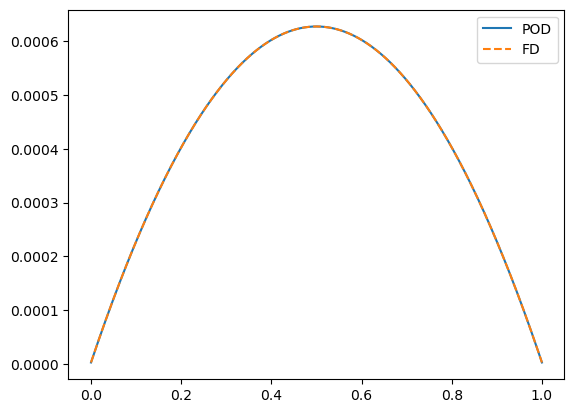

In [32]:
new_D = 200
solver.change_D(new_D=new_D)
U_FD = solver.solve()

U_POD = all_methods['POD'].apply_method(new_D)
plt.plot(solver.x, U_POD, label='POD')
plt.plot(solver.x, U_FD, '--', label='FD')
plt.legend()
plt.show()